# CIFAR 10

## Importing libraries

In [1]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from sklearn.model_selection import cross_val_predict

Using TensorFlow backend.


## Fetching the data and looking at some images

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10


y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [0]:
label_to_class={0 : 'airplane',
                1 : 'automobile',
                2 : 'bird',
                3 : 'cat',
                4 : 'deer',
                5 : 'dog',
                6 : 'frog',
                7 : 'horse',
                8 : 'ship',
                9 : 'truck'}

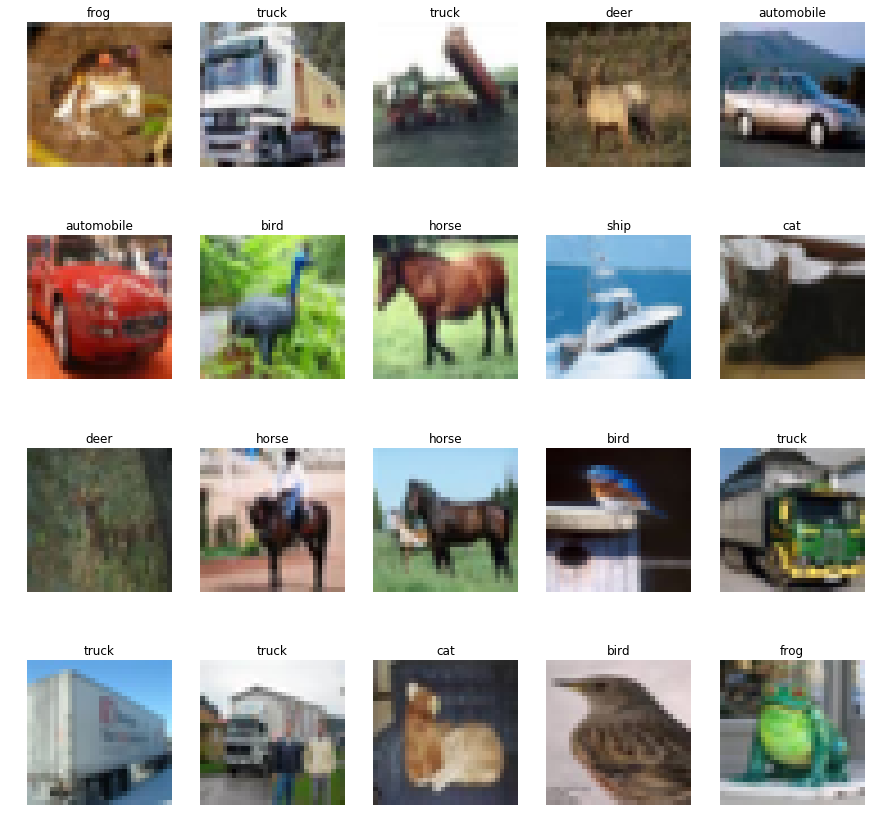

In [4]:
_,ax = plt.subplots(4,5, figsize = (15,15)) 
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(x_train[5*i+j])
        ax[i,j].set_title(label_to_class[np.argmax(y_train[5*i+j])])
        ax[i,j].axis('off')

The images from the training dataset are blurry, the dimension is only 32x32.

The images are already shuffled.

## Creating the data generators

In [0]:
epochs = 100

#Image Generator
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

## Trying a simple CNN

In [0]:
first_model = Sequential()

first_model.add(Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)))

#The batch normalization allows the model to converge much faster
first_model.add(BatchNormalization())
first_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
first_model.add(MaxPooling2D(2,2))

first_model.add(BatchNormalization())
first_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
first_model.add(MaxPooling2D(2,2))
first_model.add(Flatten())

first_model.add(Dense(128, activation='relu'))
first_model.add(Dense(128, activation='relu'))
first_model.add(Dropout(rate=0.3))

first_model.add(Dense(num_classes,activation='softmax'))

first_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])

first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [0]:
first_training = first_model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),
                                           steps_per_epoch=len(x_train) / 32,
                                           epochs=epochs,
                                           validation_data=(x_test,y_test))

Epoch 1/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.7560 - acc: 0.3626 - val_loss: 1.3868 - val_acc: 0.5005
Epoch 2/100
1563/1562 [==============================] - 30s 19ms/step - loss: 1.4821 - acc: 0.4675 - val_loss: 1.4071 - val_acc: 0.5092
Epoch 3/100
1563/1562 [==============================] - 30s 19ms/step - loss: 1.3667 - acc: 0.5110 - val_loss: 1.4051 - val_acc: 0.5288
Epoch 4/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.2805 - acc: 0.5477 - val_loss: 1.1770 - val_acc: 0.5920
Epoch 5/100
1563/1562 [==============================] - 30s 20ms/step - loss: 1.2242 - acc: 0.5676 - val_loss: 1.1206 - val_acc: 0.6109
Epoch 6/100
1563/1562 [==============================] - 30s 19ms/step - loss: 1.1712 - acc: 0.5866 - val_loss: 1.0018 - val_acc: 0.6456
Epoch 7/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.1305 - acc: 0.5998 - val_loss: 1.1489 - val_acc: 0.6104
Epoch 8/100
1563/1562 [==================

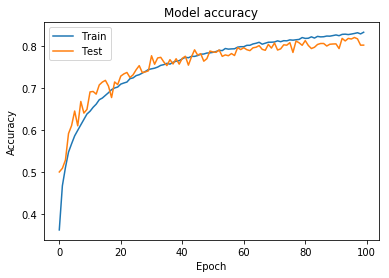

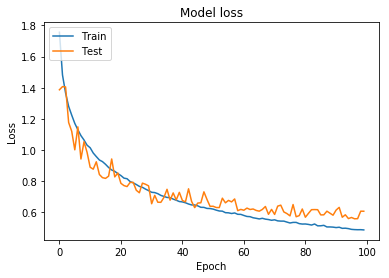

In [0]:
plt.plot(first_training.history['acc'])
plt.plot(first_training.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(first_training.history['loss'])
plt.plot(first_training.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
Y_predict = first_model.predict(x_test)
y_predict = np.argmax(Y_predict, axis = 1)

In [0]:
c=0

for i in range(len(y_predict)):
  if y_predict[i]==np.argmax(y_test[i]):
    c+=1

print("Accuracy :")
print(c/len(y_predict))

Accuracy :
0.8025


In [0]:
conf_mx=confusion_matrix(np.argmax(y_test,axis=1), y_predict)
print('Confusion Matrix')
print(conf_mx)

Confusion Matrix
[[841  39  29   7   7   1   4   2  57  13]
 [  5 973   0   0   0   0   0   0   8  14]
 [ 59   5 776  28  31  24  47  10  12   8]
 [ 28  20  70 584  34  95  93  28  40   8]
 [ 15   3  98  19 752  16  62  25  10   0]
 [ 11   7  55  89  30 730  36  32   6   4]
 [  4   7  25  17   8   3 917   2  14   3]
 [ 26   5  35  13  59  14  21 816   2   9]
 [ 52  32   2   2   0   1   4   2 898   7]
 [ 31 186   3   2   1   2  12   4  21 738]]


In [0]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx)

## Let's try a deeper network

In [0]:
model = Sequential()
    
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))    
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
    
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [0]:
training_1 = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=len(x_train) / 32,
                                 epochs=epochs,
                                 validation_data=(x_test,y_test))

Epoch 1/100
1563/1562 [==============================] - 35s 22ms/step - loss: 1.9611 - acc: 0.2928 - val_loss: 1.5297 - val_acc: 0.4460
Epoch 2/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.6563 - acc: 0.3976 - val_loss: 1.4333 - val_acc: 0.4731
Epoch 3/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.5456 - acc: 0.4391 - val_loss: 1.2704 - val_acc: 0.5432
Epoch 4/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.4643 - acc: 0.4730 - val_loss: 1.2517 - val_acc: 0.5542
Epoch 5/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.4007 - acc: 0.4945 - val_loss: 1.2507 - val_acc: 0.5499
Epoch 6/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.3386 - acc: 0.5173 - val_loss: 1.1399 - val_acc: 0.5936
Epoch 7/100
1563/1562 [==============================] - 31s 20ms/step - loss: 1.2921 - acc: 0.5391 - val_loss: 1.1948 - val_acc: 0.5750
Epoch 8/100
1563/1562 [==================

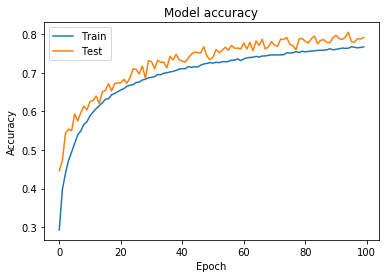

In [0]:
plt.plot(training_1.history['acc'])
plt.plot(training_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(training_1.history['loss'])
plt.plot(training_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Transfer learning with ResNet50

In [0]:
from keras.applications.resnet50 import ResNet50

In [11]:
transfer_model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
transfer_model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
transfer_model.add(Dense(num_classes, activation = 'softmax'))

# We choose to train the ResNet model
transfer_model.layers[0].trainable = True

transfer_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.00003),metrics=['accuracy'])

transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
training_2 = transfer_model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),
                                          steps_per_epoch=len(x_train) / 32,
                                          epochs=80,
                                          validation_data=(x_test,y_test))

Epoch 1/80
1563/1562 [==============================] - 150s 96ms/step - loss: 1.9341 - acc: 0.3810 - val_loss: 1.3548 - val_acc: 0.5523
Epoch 2/80
1563/1562 [==============================] - 138s 88ms/step - loss: 1.3047 - acc: 0.5529 - val_loss: 1.0479 - val_acc: 0.6470
Epoch 3/80
1563/1562 [==============================] - 137s 88ms/step - loss: 1.0904 - acc: 0.6231 - val_loss: 0.9566 - val_acc: 0.6724
Epoch 4/80
1563/1562 [==============================] - 138s 88ms/step - loss: 0.9668 - acc: 0.6634 - val_loss: 0.8193 - val_acc: 0.7216
Epoch 5/80
1563/1562 [==============================] - 136s 87ms/step - loss: 0.8796 - acc: 0.6935 - val_loss: 0.7451 - val_acc: 0.7450
Epoch 6/80
1563/1562 [==============================] - 136s 87ms/step - loss: 0.8122 - acc: 0.7172 - val_loss: 0.7403 - val_acc: 0.7480
Epoch 7/80
1563/1562 [==============================] - 137s 87ms/step - loss: 0.7540 - acc: 0.7365 - val_loss: 0.6683 - val_acc: 0.7703
Epoch 8/80
1563/1562 [===================

The accuracy on the validation set is a bit better with this model.

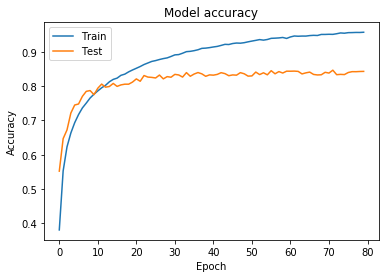

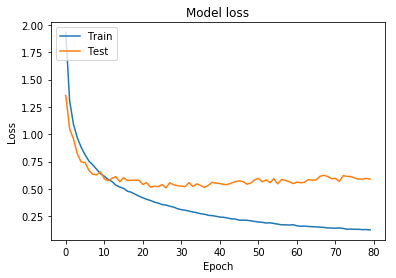

In [13]:
plt.plot(training_2.history['acc'])
plt.plot(training_2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(training_2.history['loss'])
plt.plot(training_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**This model is very powerful and does not contain enough regularization features for this problem : it is overfitting the training data.**